In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
from tqdm import tqdm

In [2]:
# os.makedirs('new_data', exist_ok=True)
# for year in tqdm(range(2000, 2024)):
#     pd.read_html(f'https://www.basketball-reference.com/leagues/NBA_{year}_totals.html')[0].to_csv(f'new_data/player_{year}.csv', index=False)

In [3]:
def process_year(year):

    # load data
    data = pd.read_csv(f'new_data/player_{year}.csv')

    # get rid of unnecessary rows
    data = data[(data['Player'] != 'Player') & (data['Pos'] != 'Pos')]

    # set season
    
    data['Season'] = year
    data['Trend'] = year - 2000

    first_column = data.pop('Season')
    data.insert(0, 'Season', first_column) 

    # convert data types to float
    convert_dict = {col: float for col in ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
        '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
        'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
        }
    data = data.astype(
        convert_dict
        
    )

    # subtract points made from 3 from total points
    data['PTS'] = data['PTS'] - 3* data['3P']

    # drop duplicated rows for players who played for multiple teams, keep the last team they played for
    data = data.sort_values(by='G', ascending=False)
    data = data.drop_duplicates(subset='Player')
    data.reset_index(drop=True, inplace=True)



    game_played_thredhold = data.groupby('Tm').max()['G'].to_dict()

    # drop players who played less than 1/4 of the player who played the most games for that team
    for team in game_played_thredhold:
        data = data[~((data['Tm'] == team) & (data['G'] < game_played_thredhold[team]/4))]


    return data

In [4]:
players = pd.DataFrame()
for year in tqdm(range(2000, 2024)):
    cur_year = process_year(year)
    players = pd.concat([players, cur_year], ignore_index=True, axis=0)
players

100%|██████████| 24/24 [00:00<00:00, 61.07it/s]


,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,Trend
0,2000,144,Chris Gatling,PF,32.0,TOT,85.0,0.0,1811.0,365.0,...,154.0,348.0,502.0,71.0,82.0,23.0,169.0,246.0,960.0,0
1,2000,290,Johnny Newman,SF,36.0,NJN,82.0,9.0,1763.0,278.0,...,39.0,115.0,154.0,65.0,53.0,11.0,89.0,207.0,604.0,0
2,2000,421,Chris Whitney,PG,28.0,WAS,82.0,15.0,1627.0,217.0,...,20.0,114.0,134.0,313.0,55.0,5.0,107.0,166.0,354.0,0
3,2000,154,A.C. Green,PF,36.0,LAL,82.0,82.0,1929.0,173.0,...,160.0,326.0,486.0,80.0,53.0,18.0,53.0,127.0,410.0,0
4,2000,286,Dikembe Mutombo*,C,33.0,ATL,82.0,82.0,2984.0,322.0,...,304.0,853.0,1157.0,105.0,27.0,269.0,174.0,248.0,942.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9618,2023,50,Brandon Boston Jr.,SF,21.0,LAC,22.0,1.0,248.0,51.0,...,7.0,23.0,30.0,20.0,9.0,0.0,12.0,21.0,107.0,23
9619,2023,118,Moussa Diabaté,C,21.0,LAC,22.0,1.0,195.0,24.0,...,31.0,19.0,50.0,4.0,7.0,8.0,9.0,15.0,56.0,23
9620,2023,119,Mamadi Diakite,C,26.0,CLE,22.0,2.0,176.0,24.0,...,8.0,22.0,30.0,8.0,4.0,9.0,12.0,26.0,36.0,23
9621,2023,136,Kris Dunn,PG,28.0,UTA,22.0,3.0,568.0,116.0,...,9.0,91.0,100.0,124.0,25.0,10.0,35.0,58.0,239.0,23


In [5]:
players.columns

Index(['Season', 'Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG',
       'FGA', 'FG%', '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT',
       'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'PTS', 'Trend'],
      dtype='object')

In [6]:
salaries = pd.read_csv(os.path.join('data', 'nba-salaries.csv'))
salaries['salary'] = salaries['salary']/1_000
salaries

,rank,name,position,team,salary,season
0,1,Shaquille O'Neal,C,Los Angeles Lakers,17142.000,2000
1,2,Kevin Garnett,PF,Minnesota Timberwolves,16806.000,2000
2,3,Alonzo Mourning,C,Miami Heat,15004.000,2000
3,4,Juwan Howard,PF,Washington Wizards,15000.000,2000
4,5,Scottie Pippen,SF,Portland Trail Blazers,14795.000,2000
...,...,...,...,...,...,...
9451,524,Jimmer Fredette,G,Phoenix Suns,208.509,2020
9452,525,Jontay Porter,PF,Memphis Grizzlies,197.933,2020
9453,526,Anthony Tolliver,PF,Memphis Grizzlies,183.115,2020
9454,527,Tyler Johnson,SG,Phoenix Suns,183.115,2020


In [7]:
df = players.merge(salaries, left_on=['Player', 'Season'], right_on=['name', 'season'])
seasons = pd.get_dummies(df['Season'], drop_first=True, prefix="season")
teams = pd.get_dummies(df['Tm'], drop_first=True, prefix="team")
positions = pd.get_dummies(df['Pos'], drop_first=True, prefix="position")
df = pd.concat([df, seasons, teams, positions], axis=1)
df
## old data only has 5266 after merging, new data has 7441

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_PG-SF,position_PG-SG,position_SF,position_SF-C,position_SF-PF,position_SF-SG,position_SG,position_SG-PF,position_SG-PG,position_SG-SF
0,2000,143,Pat Garrity,SF,23.0,ORL,82.0,1.0,1479.0,258.0,...,0,0,1,0,0,0,0,0,0,0
1,2000,135,Rick Fox,SF,30.0,LAL,82.0,1.0,1473.0,206.0,...,0,0,1,0,0,0,0,0,0,0
2,2000,292,Dirk Nowitzki,PF,21.0,DAL,82.0,81.0,2938.0,515.0,...,0,0,0,0,0,0,0,0,0,0
3,2000,111,Michael Dickerson,SG,24.0,VAN,82.0,82.0,3103.0,554.0,...,0,0,0,0,0,0,1,0,0,0
4,2000,99,Baron Davis,PG,20.0,CHH,82.0,0.0,1523.0,182.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6541,2020,252,Amile Jefferson,PF,26.0,ORL,18.0,0.0,74.0,5.0,...,0,0,0,0,0,0,0,0,0,0
6542,2020,335,Chimezie Metu,C,22.0,SAS,18.0,0.0,105.0,24.0,...,0,0,0,0,0,0,0,0,0,0
6543,2020,9,Al-Farouq Aminu,PF,29.0,ORL,18.0,2.0,380.0,25.0,...,0,0,0,0,0,0,0,0,0,0
6544,2020,191,Blake Griffin,PF,30.0,DET,18.0,18.0,512.0,88.0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Shfit the salary to the next year

df = df.sort_values(by=['Player', 'Season'])

# Group by 'Player' and then shift the 'salary' column by 1 to get the previous year's salary
df['last_year_salary'] = df.groupby('Player')['salary'].shift(1)

# Replace the NaN values for players who did not play last year
df['last_year_salary'] = df['last_year_salary'].replace({np.nan: None}).astype(float)

In [9]:
df

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_PG-SG,position_SF,position_SF-C,position_SF-PF,position_SF-SG,position_SG,position_SG-PF,position_SG-PG,position_SG-SF,last_year_salary
152,2001,152,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,144.0,...,0,0,0,0,0,0,0,0,0,NaN
404,2001,155,A.J. Guyton,PG,22.0,CHI,33.0,8.0,630.0,78.0,...,0,0,0,0,0,0,0,0,0,NaN
684,2002,160,A.J. Guyton,PG,23.0,CHI,45.0,6.0,607.0,88.0,...,0,0,0,0,0,0,0,0,0,316.000
2807,2010,335,A.J. Price,PG,23.0,IND,56.0,2.0,865.0,145.0,...,0,0,0,0,0,0,0,0,0,NaN
3185,2011,339,A.J. Price,PG,24.0,IND,50.0,0.0,795.0,114.0,...,0,0,0,0,0,0,0,0,0,457.588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,2007,195,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,385.0,...,0,0,0,0,0,0,0,0,0,8743.238
2037,2008,201,Zydrunas Ilgauskas,C,32.0,CLE,73.0,73.0,2222.0,417.0,...,0,0,0,0,0,0,0,0,0,9442.697
2425,2009,199,Zydrunas Ilgauskas,C,33.0,CLE,65.0,65.0,1765.0,342.0,...,0,0,0,0,0,0,0,0,0,10142.156
2774,2010,213,Zydrunas Ilgauskas,C,34.0,CLE,64.0,6.0,1339.0,194.0,...,0,0,0,0,0,0,0,0,0,10841.615


In [10]:
df['G'].describe()

count    6546.000000
mean       61.148488
std        17.693881
min        16.000000
25%        49.000000
50%        65.000000
75%        76.000000
max        85.000000
Name: G, dtype: float64

In [11]:
# list(df.columns)

In [12]:
df['3PPerMP'] = df['3P'] / df['MP']
df['PTSPerMP'] = df['PTS'] / df['MP']
df['TRBPerMP'] = df['TRB'] / df['MP']
df['ASTPerMP'] = df['AST'] / df['MP']
df['PFPerMP'] = df['PF'] / df['MP']
df['STLPerMP'] = df['STL'] / df['MP']

In [13]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,6546.000000,6546.000000,6546.000000,6546.000000,6546.000000,6546.000000
mean,0.028060,0.298145,0.176708,0.082397,0.095422,0.030786
std,0.026025,0.117063,0.078469,0.055061,0.034491,0.012131
min,0.000000,0.005714,0.034653,0.000000,0.025000,0.000000
25%,0.000965,0.213042,0.110633,0.042664,0.070822,0.022174
50%,0.025629,0.287867,0.160804,0.064180,0.088656,0.029207
75%,0.047619,0.371268,0.233500,0.109754,0.113690,0.037632
max,0.151866,0.829421,0.488053,0.330706,0.323944,0.115789


In [14]:
df[(df['Player']=='Damion James') & (df['Season']==2013)]

,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_SG-PF,position_SG-PG,position_SG-SF,last_year_salary,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP


In [15]:
display(df[df['TRBPerMP'] == np.inf][['TRB', 'MP', 'Player', 'Season']])

df = df[~((df['Player']=='Damion James') & (df['Season']==2013))]
df

,TRB,MP,Player,Season


,Season,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,...,position_SG-PF,position_SG-PG,position_SG-SF,last_year_salary,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
152,2001,152,A.C. Green,PF,37.0,MIA,82.0,1.0,1411.0,144.0,...,0,0,0,NaN,0.000000,0.260099,0.221828,0.027640,0.084337,0.021262
404,2001,155,A.J. Guyton,PG,22.0,CHI,33.0,8.0,630.0,78.0,...,0,0,0,NaN,0.042857,0.185714,0.057143,0.101587,0.055556,0.014286
684,2002,160,A.J. Guyton,PG,23.0,CHI,45.0,6.0,607.0,88.0,...,0,0,0,316.000,0.075783,0.174629,0.072488,0.133443,0.037891,0.016474
2807,2010,335,A.J. Price,PG,23.0,IND,56.0,2.0,865.0,145.0,...,0,0,0,NaN,0.069364,0.265896,0.101734,0.122543,0.061272,0.040462
3185,2011,339,A.J. Price,PG,24.0,IND,50.0,0.0,795.0,114.0,...,0,0,0,457.588,0.051572,0.251572,0.090566,0.139623,0.076730,0.036478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1637,2007,195,Zydrunas Ilgauskas,C,31.0,CLE,78.0,78.0,2130.0,385.0,...,0,0,0,8743.238,0.000000,0.434272,0.281221,0.057746,0.120657,0.022535
2037,2008,201,Zydrunas Ilgauskas,C,32.0,CLE,73.0,73.0,2222.0,417.0,...,0,0,0,9442.697,0.000000,0.463096,0.306931,0.046805,0.111161,0.015302
2425,2009,199,Zydrunas Ilgauskas,C,33.0,CLE,65.0,65.0,1765.0,342.0,...,0,0,0,10142.156,0.008499,0.449292,0.277620,0.036261,0.103683,0.015864
2774,2010,213,Zydrunas Ilgauskas,C,34.0,CLE,64.0,6.0,1339.0,194.0,...,0,0,0,10841.615,0.008215,0.329350,0.257655,0.035848,0.136669,0.010456


In [16]:
# interaction terms
for year in range(2001, 2021):
    df[f'3PPerMPxseason_{year}'] = df.loc[:, '3PPerMP'] * df.loc[:, f'season_{year}']
df['3PPerMPxTrend'] = df['3PPerMP'] * df['Trend']

In [17]:
df['TRB'].describe(), df['MP'].describe()

(count    6546.000000
 mean      255.244730
 std       188.089238
 min         6.000000
 25%       116.000000
 50%       214.500000
 75%       346.000000
 max      1247.000000
 Name: TRB, dtype: float64,
 count    6546.000000
 mean     1465.252521
 std       806.570984
 min        49.000000
 25%       776.000000
 50%      1438.000000
 75%      2100.000000
 max      3443.000000
 Name: MP, dtype: float64)

In [18]:
df[['3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].describe()

,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
count,6546.000000,6546.000000,6546.000000,6546.000000,6546.000000,6546.000000
mean,0.028060,0.298145,0.176708,0.082397,0.095422,0.030786
std,0.026025,0.117063,0.078469,0.055061,0.034491,0.012131
min,0.000000,0.005714,0.034653,0.000000,0.025000,0.000000
25%,0.000965,0.213042,0.110633,0.042664,0.070822,0.022174
50%,0.025629,0.287867,0.160804,0.064180,0.088656,0.029207
75%,0.047619,0.371268,0.233500,0.109754,0.113690,0.037632
max,0.151866,0.829421,0.488053,0.330706,0.323944,0.115789


# EDA

<AxesSubplot:ylabel='Frequency'>

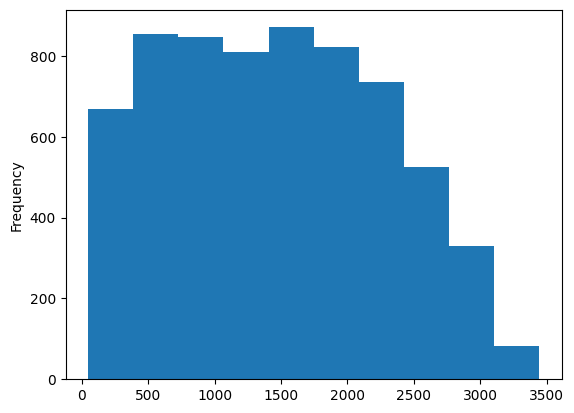

In [19]:
df['MP'].plot(kind='hist')

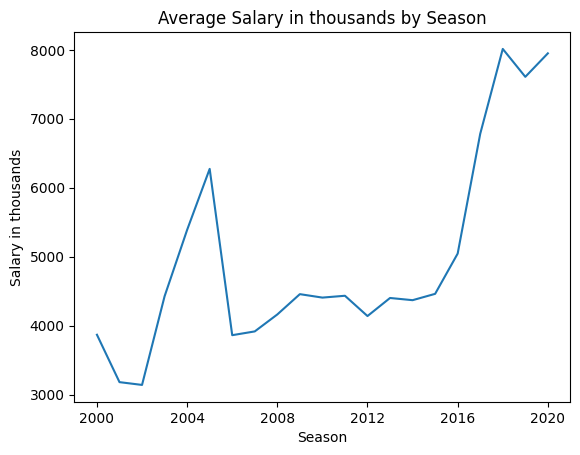

In [20]:
df.groupby('Season').mean()['salary'].plot(kind='line', xticks=range(2000, 2021, 4), title="Average Salary in thousands by Season")
plt.ylabel('Salary in thousands')
plt.show()

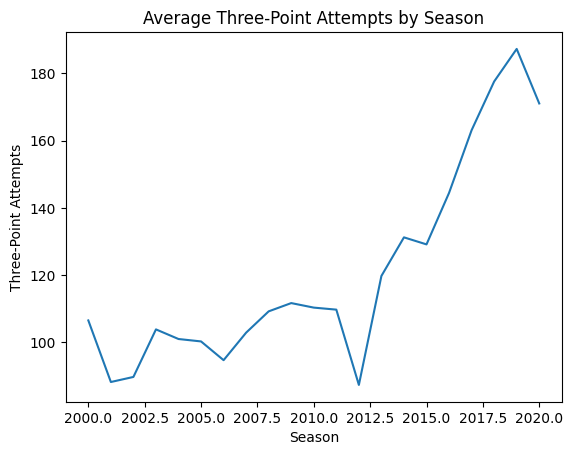

In [21]:
df.groupby('Season').mean()['3PA'].plot(kind='line', title="Average Three-Point Attempts by Season")
plt.ylabel('Three-Point Attempts')
plt.show()

# Model

In [22]:
list(df.columns)

['Season',
 'Rk',
 'Player',
 'Pos',
 'Age',
 'Tm',
 'G',
 'GS',
 'MP',
 'FG',
 'FGA',
 'FG%',
 '3P',
 '3PA',
 '3P%',
 '2P',
 '2PA',
 '2P%',
 'eFG%',
 'FT',
 'FTA',
 'FT%',
 'ORB',
 'DRB',
 'TRB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'Trend',
 'rank',
 'name',
 'position',
 'team',
 'salary',
 'season',
 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 'team_BOS',
 'team_BRK',
 'team_CHA',
 'team_CHH',
 'team_CHI',
 'team_CHO',
 'team_CLE',
 'team_DAL',
 'team_DEN',
 'team_DET',
 'team_GSW',
 'team_HOU',
 'team_IND',
 'team_LAC',
 'team_LAL',
 'team_MEM',
 'team_MIA',
 'team_MIL',
 'team_MIN',
 'team_NJN',
 'team_NOH',
 'team_NOK',
 'team_NOP',
 'team_NYK',
 'team_OKC',
 'team_ORL',
 'team_PHI',
 'team_PHO',


In [23]:
# baseline model: all stats and this year's salary


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxseason_2001',
 '3PPerMPxseason_2002',
 '3PPerMPxseason_2003',
 '3PPerMPxseason_2004',
 '3PPerMPxseason_2005',
 '3PPerMPxseason_2006',
 '3PPerMPxseason_2007',
 '3PPerMPxseason_2008',
 '3PPerMPxseason_2009',
 '3PPerMPxseason_2010',
 '3PPerMPxseason_2011',
 '3PPerMPxseason_2012',
 '3PPerMPxseason_2013',
 '3PPerMPxseason_2014',
 '3PPerMPxseason_2015',
 '3PPerMPxseason_2016',
 '3PPerMPxseason_2017',
 '3PPerMPxseason_2018',
 '3PPerMPxseason_2019',
 '3PPerMPxseason_2020'
       ]


#ThreePointersMade/Seconds

X = df[independent_vars]  # Independent variables
y = df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     47.09
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:48:48   Log-Likelihood:                -64044.
No. Observations:                6546   AIC:                         1.282e+05
Df Residuals:                    6498   BIC:                         1.285e+05
Df Model:                          47                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -3875.6876    572.660     -6.768      0.000   -4998.080   -2753.295
GS                     54.1584      2.126     25.476      0.000      49.992      58.325
3PPerMP              3451.3320   1.14e+04      0.304      0.761   -1.88e+04    2.57e+04
PTSPerMP             1.029e+04    639.487     16.089      0.000    9035.290    1.15e+04
TRBPerMP             1.672e+04   1170.680     14.282      0.000    1.44e+04     1.9e+04
ASTPerMP             1.617e+04   1478.659     10.937      0.000    1.33e+04    1.91e+04
PFPerMP             -1.473e+04   1890.499     -7.789      0.000   -1.84e+04    -1.1e+04
STLPerMP            -1.948e+04   4692.611     -4.152      0.000   -2.87e+04   -1.03e+04
season_2001           -80.3547    412.037     -0.195      0.845    -887.932     727.223
season_2002          -261.8767    409.710     -0.639      0.523   -1064.894     541.141
season_2003           630.2103    487.370      1.293      0.196    -325.017    1585.438
season_2004          1170.7020    569.170      2.057      0.040      55.149    2286.255
season_2005          2532.8657    676.823      3.742      0.000    1206.318    3859.413
season_2006           550.9169    407.571      1.352      0.176    -247.908    1349.742
season_2007           356.2578    408.907      0.871      0.384    -445.184    1157.700
season_2008           255.4511    431.149      0.592      0.554    -589.585    1100.487
season_2009           568.6449    448.741      1.267      0.205    -310.872    1448.162
season_2010           376.7029    443.903      0.849      0.396    -493.331    1246.737
season_2011           456.0656    435.567      1.047      0.295    -397.630    1309.761
season_2012           771.0467    427.002      1.806      0.071     -65.863    1607.956
season_2013           443.0788    436.392      1.015      0.310    -412.234    1298.392
season_2014           637.4895    462.417      1.379      0.168    -268.832    1543.811
season_2015           295.4374    454.061      0.651      0.515    -594.506    1185.380
season_2016           498.0811    509.452      0.978      0.328    -500.426    1496.588
season_2017          1721.4492    600.769      2.865      0.004     543.963    2898.935
season_2018          1726.1182    721.582      2.392      0.017     311.843    3140.393
season_2019          1132.6799    786.930      1.439      0.150    -409.675    2675.035
season_2020          1682.6875    775.549      2.170      0.030     162.638    3202.737
3PPerMPxseason_2001  1.518e+04   1.36e+04      1.115      0.265   -1.15e+04    4.19e+04
3PPerMPxseason_2002   1.77e+04   1.32e+04      1.338      0.181   -8233.444    4.36e+04
3PPerMPxseason_2003  1.208e+04    1.7e+04      0.710      0.478   -2.13e+04    4.54e+04
3PPerMPxseason_2004  2.762e+04   1.98e+04      1.396      0.163   -1.12e+04    6.64e+04
3PP

In [24]:
df[['GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP']].corr()

,GS,3PPerMP,PTSPerMP,TRBPerMP,ASTPerMP,PFPerMP,STLPerMP
GS,1.000000,0.049596,0.358441,0.048782,0.197113,-0.357772,0.064697
3PPerMP,0.049596,1.000000,-0.310367,-0.533175,0.245579,-0.439997,0.084180
PTSPerMP,0.358441,-0.310367,1.000000,0.318058,0.094901,-0.066170,-0.006960
TRBPerMP,0.048782,-0.533175,0.318058,1.000000,-0.472361,0.462433,-0.223142
ASTPerMP,0.197113,0.245579,0.094901,-0.472361,1.000000,-0.411528,0.398600
PFPerMP,-0.357772,-0.439997,-0.066170,0.462433,-0.411528,1.000000,-0.135398
STLPerMP,0.064697,0.084180,-0.006960,-0.223142,0.398600,-0.135398,1.000000


In [25]:
# model2: all stats and last year's salary


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',

 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxseason_2001',
 '3PPerMPxseason_2002',
 '3PPerMPxseason_2003',
 '3PPerMPxseason_2004',
 '3PPerMPxseason_2005',
 '3PPerMPxseason_2006',
 '3PPerMPxseason_2007',
 '3PPerMPxseason_2008',
 '3PPerMPxseason_2009',
 '3PPerMPxseason_2010',
 '3PPerMPxseason_2011',
 '3PPerMPxseason_2012',
 '3PPerMPxseason_2013',
 '3PPerMPxseason_2014',
 '3PPerMPxseason_2015',
 '3PPerMPxseason_2016',
 '3PPerMPxseason_2017',
 '3PPerMPxseason_2018',
 '3PPerMPxseason_2019',
 '3PPerMPxseason_2020'
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['last_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

/Users/weiyueli/opt/anaconda3/envs/nba3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 47, but rank is 46
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       last_year_salary   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     172.1
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:48:48   Log-Likelihood:                -51312.
No. Observations:                5224   AIC:                         1.027e+05
Df Residuals:                    5178   BIC:                         1.030e+05
Df Model:                          45                                         
Covariance Type:                  HC1                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -1189.9789    479.081     -2.484      0.013   -2128.960    -250.998
GS                     36.7668      2.419     15.198      0.000      32.025      41.508
3PPerMP              2.572e+04   3303.099      7.786      0.000    1.92e+04    3.22e+04
PTSPerMP             7679.6925    697.422     11.012      0.000    6312.771    9046.614
TRBPerMP             1.587e+04   1325.334     11.976      0.000    1.33e+04    1.85e+04
ASTPerMP             1.566e+04   1596.923      9.804      0.000    1.25e+04    1.88e+04
PFPerMP             -1.386e+04   2465.666     -5.620      0.000   -1.87e+04   -9024.779
STLPerMP            -2.877e+04   5577.902     -5.157      0.000   -3.97e+04   -1.78e+04
season_2001          -676.9899    362.511     -1.868      0.062   -1387.498      33.518
season_2002         -1135.1297    249.937     -4.542      0.000   -1624.998    -645.262
season_2003          -850.8901    287.724     -2.957      0.003   -1414.819    -286.961
season_2004          -166.7083    391.384     -0.426      0.670    -933.806     600.390
season_2005           902.6787    515.411      1.751      0.080    -107.507    1912.865
season_2006           -42.0015    397.904     -0.106      0.916    -821.878     737.875
season_2007          -805.6060    263.270     -3.060      0.002   -1321.605    -289.607
season_2008          -631.5437    298.765     -2.114      0.035   -1217.112     -45.975
season_2009          -314.5815    307.910     -1.022      0.307    -918.074     288.910
season_2010          -349.7887    322.585     -1.084      0.278    -982.044     282.467
season_2011          -296.1026    316.152     -0.937      0.349    -915.748     323.543
season_2012            42.4005    324.387      0.131      0.896    -593.386     678.187
season_2013          -345.9314    317.559     -1.089      0.276    -968.336     276.473
season_2014           109.3104    341.040      0.321      0.749    -559.116     777.737
season_2015          -165.0616    350.935     -0.470      0.638    -852.882     522.759
season_2016          -153.0716    396.610     -0.386      0.700    -930.412     624.269
season_2017          -227.7660    467.203     -0.488      0.626   -1143.467     687.936
season_2018           916.5008    609.769      1.503      0.133    -278.625    2111.627
season_2019          1451.8377    802.925      1.808      0.071    -121.866    3025.541
season_2020          1548.4655    811.800      1.907      0.056     -42.634    3139.565
3PPerMPxseason_2001 -2.838e+04   1.15e+04     -2.460      0.014    -5.1e+04   -5768.267
3PPerMPxseason_2002 -1.083e+04   7481.392     -1.448      0.148   -2.55e+04    3830.371
3PPerMPxseason_2003 -7885.2722   1.08e+04     -0.731      0.465    -2.9e+04    1.33e+04
3PPerMPxseason_2004  1383.9724    1.4e+04      0.099      0.921    -2.6e+04    2.88e+04
3PP

In [26]:
# model3: all stats and last year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


 'season_2001',
 'season_2002',
 'season_2003',
 'season_2004',
 'season_2005',
 'season_2006',
 'season_2007',
 'season_2008',
 'season_2009',
 'season_2010',
 'season_2011',
 'season_2012',
 'season_2013',
 'season_2014',
 'season_2015',
 'season_2016',
 'season_2017',
 'season_2018',
 'season_2019',
 'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['last_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

/Users/weiyueli/opt/anaconda3/envs/nba3/lib/python3.9/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 29, but rank is 28
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       last_year_salary   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     280.1
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:48:48   Log-Likelihood:                -51321.
No. Observations:                5224   AIC:                         1.027e+05
Df Residuals:                    5196   BIC:                         1.029e+05
Df Model:                          27                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1719.1566    416.204     -4.131      0.000   -2534.901    -903.412
GS               36.8492      2.420     15.230      0.000      32.107      41.591
3PPerMP        1.093e+04   6431.826      1.700      0.089   -1671.745    2.35e+04
PTSPerMP       7670.1714    698.479     10.981      0.000    6301.178    9039.164
TRBPerMP       1.592e+04   1320.969     12.054      0.000    1.33e+04    1.85e+04
ASTPerMP       1.556e+04   1595.135      9.754      0.000    1.24e+04    1.87e+04
PFPerMP       -1.424e+04   2459.372     -5.790      0.000   -1.91e+04   -9420.247
STLPerMP      -2.947e+04   5550.036     -5.309      0.000   -4.03e+04   -1.86e+04
season_2001    -437.4434    258.080     -1.695      0.090    -943.270      68.383
season_2002    -648.2038    186.425     -3.477      0.001   -1013.591    -282.817
season_2003    -400.1450    216.871     -1.845      0.065    -825.204      24.914
season_2004     368.2121    290.047      1.269      0.204    -200.270     936.694
season_2005    1182.3715    416.586      2.838      0.005     365.877    1998.866
season_2006      99.0093    302.840      0.327      0.744    -494.545     692.564
season_2007    -301.3612    197.033     -1.529      0.126    -687.539      84.816
season_2008    -491.5329    205.355     -2.394      0.017    -894.021     -89.045
season_2009    -159.0249    216.630     -0.734      0.463    -583.612     265.563
season_2010    -111.9696    216.642     -0.517      0.605    -536.580     312.641
season_2011    -325.8931    222.657     -1.464      0.143    -762.294     110.507
season_2012      26.7600    236.506      0.113      0.910    -436.783     490.303
season_2013    -686.0670    221.409     -3.099      0.002   -1120.021    -252.113
season_2014    -842.7135    226.076     -3.728      0.000   -1285.814    -399.613
season_2015    -874.3451    224.044     -3.903      0.000   -1313.462    -435.228
season_2016   -1025.9719    230.075     -4.459      0.000   -1476.911    -575.033
season_2017    -717.7981    245.835     -2.920      0.004   -1199.626    -235.971
season_2018     834.7162    334.981      2.492      0.013     178.165    1491.267
season_2019    1548.1308    353.482      4.380      0.000     855.319    2240.942
season_2020    1244.1128    382.253      3.255      0.001     494.911    1993.314
3PPerMPxTrend  1515.6429    558.020      2.716      0.007     421.944    2609.342
Trend            59.5396     20.761      2.868      0.004      18.849     100.230
==============================================================================
Omnibus:                      888.424   Durbin-Watson:                   0.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1724.662
Skew:                           1.040   Prob(JB):                         0.00
Kurtosis:                       4.896   Cond. No.            

In [27]:
# model4: all stats and last year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['last_year_salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       last_year_salary   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     116.6
Date:                Wed, 22 Nov 2023   Prob (F-statistic):          4.28e-200
Time:                        02:48:48   Log-Likelihood:                -51381.
No. Observations:                5224   AIC:                         1.028e+05
Df Residuals:                    5214   BIC:                         1.028e+05
Df Model:                           9                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2434.0621    512.116     -4.753      0.000   -3437.791   -1430.333
GS               36.6775      2.432     15.080      0.000      31.911      41.444
3PPerMP        1492.9445   6296.613      0.237      0.813   -1.08e+04    1.38e+04
PTSPerMP       7753.3403    697.694     11.113      0.000    6385.884    9120.796
TRBPerMP       1.685e+04   1339.668     12.581      0.000    1.42e+04    1.95e+04
ASTPerMP        1.66e+04   1622.287     10.232      0.000    1.34e+04    1.98e+04
PFPerMP       -1.281e+04   2438.295     -5.253      0.000   -1.76e+04   -8029.941
STLPerMP      -3.025e+04   5578.210     -5.423      0.000   -4.12e+04   -1.93e+04
3PPerMPxTrend  2562.4862    533.270      4.805      0.000    1517.296    3607.676
Trend            65.7038     19.614      3.350      0.001      27.262     104.146
==============================================================================
Omnibus:                     1045.422   Durbin-Watson:                   0.885
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2211.266
Skew:                           1.167   Prob(JB):                         0.00
Kurtosis:                       5.170   Cond. No.                     4.94e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# model5: all stats and last year's salary with trend


independent_vars = [
    'GS', '3PPerMP', 'PTSPerMP', 'TRBPerMP', 'ASTPerMP', 'PFPerMP', 'STLPerMP',


#  'season_2001',
#  'season_2002',
#  'season_2003',
#  'season_2004',
#  'season_2005',
#  'season_2006',
#  'season_2007',
#  'season_2008',
#  'season_2009',
#  'season_2010',
#  'season_2011',
#  'season_2012',
#  'season_2013',
#  'season_2014',
#  'season_2015',
#  'season_2016',
#  'season_2017',
#  'season_2018',
#  'season_2019',
#  'season_2020',
 '3PPerMPxTrend',
     'Trend',
       ]

new_df = df.copy()
# new_df = new_df.dropna(subset=['last_year_salary'])

#ThreePointersMade/Seconds

X = new_df[independent_vars]  # Independent variables
y = new_df['salary']  # Dependent variable

# Adding a constant term for the intercept
X = sm.add_constant(X)

# Fitting the model
model = sm.OLS(y, X).fit(cov_type='HC1')

# Getting the summary of the model
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.364
Method:                 Least Squares   F-statistic:                     228.2
Date:                Wed, 22 Nov 2023   Prob (F-statistic):               0.00
Time:                        02:48:48   Log-Likelihood:                -64128.
No. Observations:                6546   AIC:                         1.283e+05
Df Residuals:                    6536   BIC:                         1.283e+05
Df Model:                           9                                         
Covariance Type:                  HC1                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4003.2743    447.633     -8.943      0.000   -4880.619   -3125.930
GS               54.9254      2.135     25.728      0.000      50.741      59.110
3PPerMP        2404.9852   5094.807      0.472      0.637   -7580.654    1.24e+04
PTSPerMP       1.033e+04    640.182     16.140      0.000    9077.503    1.16e+04
TRBPerMP       1.749e+04   1187.001     14.733      0.000    1.52e+04    1.98e+04
ASTPerMP       1.671e+04   1502.383     11.122      0.000    1.38e+04    1.97e+04
PFPerMP       -1.399e+04   1856.731     -7.533      0.000   -1.76e+04   -1.03e+04
STLPerMP      -1.994e+04   4719.371     -4.226      0.000   -2.92e+04   -1.07e+04
3PPerMPxTrend  3305.9369    468.275      7.060      0.000    2388.134    4223.740
Trend            41.6806     15.926      2.617      0.009      10.466      72.896
==============================================================================
Omnibus:                     1554.274   Durbin-Watson:                   0.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4487.132
Skew:                           1.238   Prob(JB):                         0.00
Kurtosis:                       6.213   Cond. No.                     4.54e+03
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
[2] The condition number is large, 4.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""